In [1]:
from collections import namedtuple, OrderedDict
from copy import copy
import numpy as np
import plotter as pltr
pltr.set_backend(pltr.MatplotlibBackend)

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as dutils

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as dsets

## Data Prep and Visualizing Utils

In [3]:
means = [0.5]
stds = [0.5]
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

white = pltr.Color(red=255, green=255, blue=255)
big_white_font = pltr.Font(color=white, size=14)

Metric = namedtuple('Metric', ['name', 'train', 'val'])

def tensor2img(tensor):
    """
    Tensor of size 1xHxW: Supposed to be an image with a single channel
    Returns an ndarray of shape HxW of type int with values between 0 and 255.
    """
    img = copy(tensor.cpu().detach().numpy())
    img = img.squeeze()  # Get rid fo the single channel dim
    img = img * stds + means  # De-normalize
    img = np.clip(img, 0, 1)
    img = 255 * img  # Re-scale to 0-255
    img = img.astype(np.int)
    return img

def show_imgs(imgs, titles):
    """
    imgs: list of ndarrays of shape HxW
    titles: list of strings
    """
    frame = pltr.Frame()
    frame.layout(1, len(imgs))  # Show all the images in a single row
    for img, title in zip(imgs, titles):
        chart = frame.create_chart()
        chart.title = title
        chart.title_font = big_white_font
        chart.show_axes = False
        imgplot = pltr.GrayscaleImage(img)
        chart.add(imgplot)
    frame.show()
    
def conv_dims(n, k, s=1, p=0):
    return (n + 2*p - k)/s + 1

def deconv_dims(n, k, s=1, p=0):
    return (n-1)*s + k - 2*p

def init_weights(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

## Load MNIST data

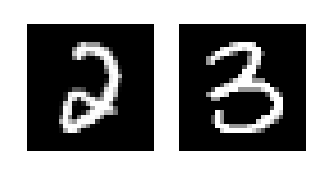

In [4]:
BATCH_SIZE = 32

xforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(means, stds)
])
trainset = dsets.MNIST('/data/pytorch/mnist', download=True, train=True, transform=xforms)
trainloader = dutils.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
images, labels = next(iter(trainloader))
imgs = [tensor2img(images[0]), tensor2img(images[1])]
titles = [str(labels[0].item()), str(labels[1].item())]
show_imgs(imgs, titles)

## Define the Networks

## Discriminator Network

#### Layer 1
1x28x28 -- CONV(3) --> RELU --> 64x26x26

#### Layer 2
64x?x? -- CONV(3) --> BNORM --> RELU --> 128x24x24

#### Layer 3
128x24x24 -- CONV(4, 2, 1) --> BNORM --> RELU --> 256x12x12

#### Layer 4
256x12x12 -- CONV(4, 2, 1) --> BNORM --> RELU --> 512x6x6

#### Layer 5
512x6x6 -- CONV(6, 1) --> 1x1x1 -- SIGMOID --> 1

In [5]:
discriminator = nn.Sequential(OrderedDict([
    ('conv1', nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, bias=False)),
    ('relu1', nn.LeakyReLU(0.2, inplace=True)),
    
    ('conv2', nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, bias=False)),
    ('bn2', nn.BatchNorm2d(128)),
    ('relu2', nn.LeakyReLU(0.2, inplace=True)),
    
    ('conv3', nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False)),
    ('bn3', nn.BatchNorm2d(256)),
    ('relu3', nn.LeakyReLU(0.2, inplace=True)),
    
    ('conv4', nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False)),
    ('bn4', nn.BatchNorm2d(512)),
    ('relu4', nn.LeakyReLU(0.2, inplace=True)),
    
    ('conv5', nn.Conv2d(in_channels=512, out_channels=1, kernel_size=6, bias=False)),
    ('sigmoid', nn.Sigmoid())
]))

discriminator.to(DEVICE)
discriminator.apply(init_weights)

Sequential(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (relu1): LeakyReLU(negative_slope=0.2, inplace)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): LeakyReLU(negative_slope=0.2, inplace)
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): LeakyReLU(negative_slope=0.2, inplace)
  (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu4): LeakyReLU(negative_slope=0.2, inplace)
  (conv5): Conv2d(512, 1, kernel_size=(6, 6), stride=(1, 1), bias=False)
  (sigmoid): Sigmoid()
)

## Generator Network

The input noise vector will be z_dims in size. When it goes into the deconv layer, think of it as a 1x1 image with z_dims channels going in. Let z_dims be 100.

#### Layer 1
100x1x1 -- DECONV(6) --> BNORM --> RELU --> 512x6x6

#### Layer 2
512x6x6 -- DECONV(4, 2, 1) --> BNORM --> RELU --> 256x12x12

#### Layer 3
256x12x12 -- DECONV(4, 2, 1) --> BNORM --> RELU --> 128x24x24

#### Layer 4
128x24x24 -- DECONV(3) --> BNORM --> RELU --> 64x26x26

#### Layer 5
64x26x26 -- DECONV(3) --> TANH --> 1x28x28

In [6]:
generator = nn.Sequential(OrderedDict([
    ('deconv1', nn.ConvTranspose2d(in_channels=100, out_channels=512, kernel_size=6, bias=False)),
    ('bn1', nn.BatchNorm2d(512)),
    ('relu1', nn.ReLU(512)),
    
    ('deconv2', nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False)),
    ('bn2', nn.BatchNorm2d(256)),
    ('relu2', nn.ReLU(True)),
    
    ('deconv3', nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False)),
    ('bn3', nn.BatchNorm2d(128)),
    ('relu3', nn.ReLU(True)),
    
    ('deconv4', nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, bias=False)),
    ('bn4', nn.BatchNorm2d(64)),
    ('relu4', nn.ReLU(True)),
    
    ('deconv5', nn.ConvTranspose2d(in_channels=64, out_channels=1, kernel_size=3, bias=False)),
    ('tanh', nn.Tanh())
]))

generator.to(DEVICE)
generator.apply(init_weights)

Sequential(
  (deconv1): ConvTranspose2d(100, 512, kernel_size=(6, 6), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace)
  (deconv2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU(inplace)
  (deconv3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU(inplace)
  (deconv4): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu4): ReLU(inplace)
  (deconv5): ConvTranspose2d(64, 1, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (tanh): Tanh()
)

In [7]:
loss_fn = nn.BCELoss()
real_label = 1
fake_label = 0
optimD = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimG = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [8]:
num_epochs = 3

for epoch in range(num_epochs):
    print(f'\nEpoch {epoch+1}/{num_epochs}')
    epoch_lossD = 0
    epoch_lossG = 0
    
    for images, _ in trainloader:
        print('.', end='')
        with torch.enable_grad():
            optimD.zero_grad()
            optimG.zero_grad()

            real_images = images.to(DEVICE)

            noise = torch.randn(BATCH_SIZE, 100, 1, 1, device=DEVICE)
            fake_images = generator.forward(noise)

            # Train discriminator - on real images
            labels = torch.full((BATCH_SIZE,), real_label, device=DEVICE)
            hvals = discriminator.forward(real_images).squeeze()
            lossD_real = loss_fn(hvals, labels)
            lossD_real.backward()

            # Train discriminator - on fake images
            labels.fill_(fake_label)
            hvals = discriminator.forward(fake_images.detach()).squeeze()
            lossD_fake = loss_fn(hvals, labels)
            lossD_fake.backward()

            # Update the discriminator weights
            optimD.step()

            # Train generator on fake images labeled as real
            labels.fill_(real_label)
            hvals = discriminator.forward(fake_images).squeeze()
            lossG = loss_fn(hvals, labels)
            lossG.backward()

            # Update the generator weights
            optimG.step()
            
            lossD = lossD_real + lossD_fake
            epoch_lossD += lossD
            epoch_lossG += lossG
        
    epoch_lossD = epoch_lossD / len(trainset)
    epoch_lossG = epoch_lossG / len(trainset)
    print(f'\n  Discriminator Loss: {epoch_lossD:.3f}  Generator Loss: {epoch_lossG:.3f}')
        


Epoch 1/3
........................................................................................................................................................................................................................................................................

KeyboardInterrupt: 

In [ ]:
# Train discriminator with a single batch
### Maximize log(D(x)) and log(1 - D(G(z)))
real_images, _ = next(iter(trainloader))
real_images = real_images.to(DEVICE)
with torch.enable_grad():
    optimD.zero_grad()
    
    # Train with real images
    labels = torch.full((BATCH_SIZE,), real_label, device=DEVICE)
    hvals = discriminator.forward(real_images).squeeze()
    print(hvals.size())
    loss_real = loss_fn(hvals, labels)
    loss_real.backward()
    
    # Train with fake images generated from random noise
    noise = torch.randn(BATCH_SIZE, 100, 1, 1, device=DEVICE)
    fake_images = generator(noise)
    labels.fill_(fake_label)
    hvals = discriminator(fake_images.detach()).squeeze()
    loss_fake = loss_fn(hvals, labels)
    loss_fake.backwards()
    
    # Update the weights of the discriminator
    optimD.step()    

In [ ]:
# Train generator with a single batch
#### Maximize log(D(G(z)))
with torch.enable_grad():
    optimG.zero_grad()
    labels.fill_(real_label)
    hvals = discriminator.forward(fake_images).squeeze()
    loss = loss_fn(hvals, labels)
    loss.backward()
    optimG.step()

In [9]:
len(trainloader)

1875

In [10]:
len(trainset)

60000